# Mix EMA & Couple candlesticks & Momentum - Strategy - Backtesting 

### Import Library

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
from backtesting.backtesting import Backtest, Strategy

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import seaborn as sns
# from backtesting._plotting import set_bokeh_output
# set_bokeh_output(notebook=False)
# from backtesting import set_bokeh_output
# set_bokeh_output(notebook=False)

Loading BokehJS ...

### Load Price Data

In [2]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

remote


In [3]:
data = dataset.copy()

In [4]:
# data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')]
data = data[data.index > '2020-11-01 00:00:00']

In [5]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2025-02-25 14:15:00,1358.4,1360.8,1358.2,1360.5,6708
2025-02-25 14:20:00,1360.3,1362.1,1359.4,1361.0,7025
2025-02-25 14:25:00,1361.0,1362.2,1360.8,1361.7,4896


In [6]:
def get_ema_signal(r):
    signal = ''
    if r['ema_fast_s1'] < r['ema_low_s1'] and r['ema_fast'] > r['ema_low']:
        signal = 'long'
    elif r['ema_fast_s1'] > r['ema_low_s1'] and r['ema_fast'] < r['ema_low']:
        signal = 'short'
    return signal

In [7]:
def set_condition_1(r):
    cond = ''
    if r['Open'] > r['Close'] >= r['Low'] + 0.1:
        # Do va co bong nen duoi
        cond = 'short'
    elif r['Open'] < r['Close'] <= r['High'] - 0.1:
        # Xanh va co bong nen tren
        cond = 'long'
    return cond


def set_condition_2(r):
    cond = ''
    if r['Open'] > r['Close'] == r['Low'] and r['Low'] < r['low_s1']:
        # Do va khong co bong nen duoi
        cond = 'short'
    elif r['Open'] < r['Close'] == r['High'] and r['High'] > r['high_s1']:
        # Xanh va khong co bong nen tren
        cond = 'long'
    return cond
    

def get_couple_candleticks_signal(r):
    signal = ''
    if r['condition_1'] == 'short' and r['condition_2'] == 'short':
        signal = 'short'
    elif r['condition_1'] == 'long' and r['condition_2'] == 'long':
        signal = 'long'
    return signal

In [8]:
def cal_signal(row):
    signal = ''
    if not row['first_close']:
        return signal
    if row['Close'] - row['prev_low'] > 21 or row['prev_high'] - row['Close'] > 21:
        return signal
    if row['mom_y'] > 0.26 and row['body_rate'] > .65:
        signal = 'long'
    elif row['mom_y'] < -.18 and row['body_rate'] < -.39:
        signal = 'short'
    return signal


def cal_first_close(tick):
    tick = tick[100 * tick.index.hour + tick.index.minute == 915]
    if not tick.empty:
        return tick[0]


def cal_high_before(tick):
    tick = tick[100 * tick.index.hour + tick.index.minute < 1345]
    return tick.max()


def cal_low_before(tick):
    tick = tick[100 * tick.index.hour + tick.index.minute < 1355]
    return tick.min()


def cal_last(tick):
    tick = tick[100 * tick.index.hour + tick.index.minute == 1445]
    if not tick.empty:
        return tick[0]

def cal_price(tick):
    tick = tick[100 * tick.index.hour + tick.index.minute == 1355]
    if not tick.empty:
        return tick[0]
        
def get_day_data(htd):
    data_tmp = htd.copy()
    data_tmp['first_close'] = data_tmp.Close
    data_tmp['_2pm_price'] = data_tmp.Close
    data_tmp['_last'] = data_tmp.Close
    data_tmp['prev_high'] = data_tmp.High
    data_tmp['prev_low'] = data_tmp.Low
    day_data = data_tmp.resample("D").agg({
        'first_close': cal_first_close,
        'prev_high': cal_high_before,
        'prev_low': cal_low_before,
        '_2pm_price': cal_price,
        '_last': cal_last
    }).rename(columns={'_last': 'day_Close'})
    day_data.dropna(subset=['day_Close'], inplace=True)
    day_data['prev_day_Close'] = day_data['day_Close'].shift(1)
    day_data.drop(columns=['day_Close'], inplace=True)
    return day_data[['prev_day_Close', 'first_close', 'prev_high', 'prev_low']]

def add_momentum_signal(data):
    clone_data = data.copy()
    day_data = get_day_data(clone_data)
    clone_data = clone_data.assign(time_d=pd.PeriodIndex(clone_data.index, freq='1D').to_timestamp())
    df_merged = pd.merge(clone_data, day_data, left_on="time_d", right_index=True, how="left")
    # df_merged = clone_data.merge(day_data, how='left', left_index=True, right_index=True)
    df_merged['mom_y'] = df_merged.apply(lambda r: 100 * (r['Close'] - r['prev_day_Close']) / r['prev_day_Close'] if r['first_close'] else 0, axis=1)
    df_merged['body_rate'] = df_merged.apply(lambda r: (r['Close'] - r['first_close']) / (r['prev_high'] - r['prev_low']) if r['first_close'] else 0, axis=1)
    df_merged['momentum_signal'] = df_merged.apply(lambda r: cal_signal(r), axis=1)
    df_merged.loc[100 * df_merged.index.hour + df_merged.index.minute != 1355, 'momentum_signal'] = ''
    return df_merged
    

In [9]:
def prepare_data(data):
    data["current"] = data.index + pd.DateOffset(minutes=5)
    # EMA signal
    data['max_in_range'] = data['High'].rolling(10).max()
    data['min_in_range'] = data['Low'].rolling(10).min()
    data["ema_fast"] = ta.ema(data["Close"], length=20)
    data["ema_low"] = ta.ema(data["Close"], length=250)
    data['ema_fast_s1'] = data['ema_fast'].shift(1)
    data['ema_low_s1'] = data['ema_low'].shift(1)
    data['ema_signal'] = data.apply(lambda r: get_ema_signal(r), axis=1)
    # Couple candlesticks signal
    data['low_s1'] = data['Low'].shift(1)
    data['high_s1'] = data['High'].shift(1)
    data['max_5'] = data['High'].rolling(5).max()
    data['min_5'] = data['Low'].rolling(5).min()
    data['condition_1'] = data.apply(lambda r: set_condition_1(r), axis=1)
    data['condition_1'] = data['condition_1'].shift(1)
    data['condition_2'] = data.apply(lambda r: set_condition_2(r), axis=1)
    data['couple_cs_signal'] = data.apply(lambda r: get_couple_candleticks_signal(r), axis=1)
    # Momentum signal
    data = add_momentum_signal(data)
    # Optimnize
    data['RSI'] = ta.rsi(data["Close"], length=14)
    data['body'] = data.apply(lambda r: abs(r['Close'] - r['Open']), axis=1)
    data['ibs'] = data.apply(lambda x: (-10 if (x["High"] == x["Low"]) else 10 * (x["Close"] - x["Low"]) / (x["High"] - x["Low"])), axis=1)
    data["vol_20_mean"] = data["Volume"].rolling(20).mean()
    return data

In [10]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2025-02-25 14:15:00,1358.4,1360.8,1358.2,1360.5,6708
2025-02-25 14:20:00,1360.3,1362.1,1359.4,1361.0,7025
2025-02-25 14:25:00,1361.0,1362.2,1360.8,1361.7,4896


In [11]:
prepared_data = prepare_data(data)
prepared_data.dropna(subset=['Close'],inplace=True)

In [12]:
prepared_data

,Open,High,Low,Close,Volume,current,max_in_range,min_in_range,ema_fast,ema_low,...,first_close,prev_high,prev_low,mom_y,body_rate,momentum_signal,RSI,body,ibs,vol_20_mean
Date,,,,,,,,,,,,,,,,,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910,2020-11-02 09:05:00,NaN,NaN,NaN,NaN,...,898.6,901.5,895.4,NaN,0.245902,,NaN,0.0,8.888889,NaN
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670,2020-11-02 09:10:00,NaN,NaN,NaN,NaN,...,898.6,901.5,895.4,NaN,0.131148,,NaN,0.8,4.666667,NaN
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329,2020-11-02 09:15:00,NaN,NaN,NaN,NaN,...,898.6,901.5,895.4,NaN,0.147541,,NaN,0.0,5.000000,NaN
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722,2020-11-02 09:20:00,NaN,NaN,NaN,NaN,...,898.6,901.5,895.4,NaN,0.000000,,NaN,0.8,3.076923,NaN
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939,2020-11-02 09:25:00,NaN,NaN,NaN,NaN,...,898.6,901.5,895.4,NaN,-0.065574,,NaN,0.3,8.095238,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-25 14:15:00,1358.4,1360.8,1358.2,1360.5,6708,2025-02-25 14:20:00,1363.2,1358.0,1361.228844,1353.680907,...,1365.9,1367.0,1360.0,-0.424504,-0.771429,,45.242415,2.1,8.846154,3286.25
2025-02-25 14:20:00,1360.3,1362.1,1359.4,1361.0,7025,2025-02-25 14:25:00,1363.2,1358.0,1361.207050,1353.739227,...,1365.9,1367.0,1360.0,-0.387909,-0.700000,,47.729676,0.7,5.925926,3482.05
2025-02-25 14:25:00,1361.0,1362.2,1360.8,1361.7,4896,2025-02-25 14:30:00,1363.2,1358.0,1361.253997,1353.802659,...,1365.9,1367.0,1360.0,-0.336676,-0.600000,,51.079924,0.7,6.428571,3643.40


In [13]:
backtest_data = prepared_data[['Open', 'Close', 'High', 'Low', 'min_in_range', 'max_in_range', 'min_5', 'max_5', 'ema_signal', 'momentum_signal', 'couple_cs_signal']]
backtest_data[(backtest_data.ema_signal != '') | (backtest_data.momentum_signal != '') | (backtest_data.couple_cs_signal != '')]

,Open,Close,High,Low,min_in_range,max_in_range,min_5,max_5,ema_signal,momentum_signal,couple_cs_signal
Date,,,,,,,,,,,
2020-11-02 10:05:00,900.0,899.5,900.4,899.5,896.5,901.4,897.7,901.4,,,short
2020-11-02 14:25:00,904.9,907.0,907.0,904.5,896.6,907.0,896.6,907.0,,,long
2020-11-03 09:20:00,908.5,908.1,908.8,908.1,897.4,909.4,908.1,909.4,,,short
2020-11-04 09:35:00,907.8,907.3,908.0,907.3,907.3,909.9,907.3,908.8,,,short
2020-11-04 10:05:00,908.2,909.0,909.0,908.1,906.7,909.0,906.8,909.0,,,long
...,...,...,...,...,...,...,...,...,...,...,...
2025-02-24 14:10:00,1357.7,1359.8,1359.8,1357.4,1353.7,1359.8,1355.0,1359.8,,,long
2025-02-25 09:40:00,1366.0,1366.9,1366.9,1365.2,1364.3,1367.0,1364.3,1366.9,,,long
2025-02-25 10:25:00,1364.1,1364.7,1364.7,1364.1,1362.7,1367.0,1362.7,1364.7,,,long


In [14]:
backtest_data[backtest_data.momentum_signal != '']

,Open,Close,High,Low,min_in_range,max_in_range,min_5,max_5,ema_signal,momentum_signal,couple_cs_signal
Date,,,,,,,,,,,
2020-11-04 13:55:00,912.8,916.3,917.2,912.5,912.1,917.2,912.4,917.2,,long,
2020-11-06 13:55:00,908.3,907.3,908.4,906.7,903.3,908.6,903.5,908.6,,short,
2020-11-11 13:55:00,914.3,915.6,915.7,914.0,914.0,921.2,914.0,921.0,,short,
2020-11-13 13:55:00,931.6,932.9,933.4,931.2,929.2,933.4,929.2,933.4,,long,
2020-11-16 13:55:00,928.2,933.5,933.8,928.2,925.5,936.3,925.5,934.0,,short,
...,...,...,...,...,...,...,...,...,...,...,...
2025-01-17 13:55:00,1312.9,1315.4,1316.7,1312.8,1309.6,1316.7,1310.8,1316.7,,long,
2025-01-21 13:55:00,1317.6,1319.4,1319.9,1317.6,1316.6,1324.4,1316.6,1320.3,,short,
2025-02-03 13:55:00,1317.4,1315.5,1318.3,1315.5,1315.5,1321.9,1315.5,1321.0,,short,short


In [15]:
backtest_data

,Open,Close,High,Low,min_in_range,max_in_range,min_5,max_5,ema_signal,momentum_signal,couple_cs_signal
Date,,,,,,,,,,,
2020-11-02 09:00:00,900.1,900.1,900.2,899.3,NaN,NaN,NaN,NaN,,,
2020-11-02 09:05:00,900.2,899.4,900.2,898.7,NaN,NaN,NaN,NaN,,,
2020-11-02 09:10:00,899.5,899.5,900.0,899.0,NaN,NaN,NaN,NaN,,,
2020-11-02 09:15:00,899.4,898.6,899.5,898.2,NaN,NaN,NaN,NaN,,,
2020-11-02 09:20:00,898.5,898.2,898.6,896.5,NaN,NaN,896.5,900.2,,,
...,...,...,...,...,...,...,...,...,...,...,...
2025-02-25 14:15:00,1358.4,1360.5,1360.8,1358.2,1358.0,1363.2,1358.0,1362.2,,,
2025-02-25 14:20:00,1360.3,1361.0,1362.1,1359.4,1358.0,1363.2,1358.0,1362.1,,,
2025-02-25 14:25:00,1361.0,1361.7,1362.2,1360.8,1358.0,1363.2,1358.0,1362.2,,,


In [16]:
class MainStrategy(Strategy):
    max_sl = 3.5
    #
    ema_trailing_sl = 5.5
    ema_tp_step = 27
    #
    momentum_trailing_sl = 4.5
    momentum_tp_step = 27
    #
    cs_trailing_sl = 7.5
    cs_tp_step = 27
    #
    def init(self):
        self._broker._cash = 1500
        self.strategy = ''
        super().init()

    def next(self):
        super().next()
        close_price = self.data.Close[-1]
        # Strategy trailing stoploss
        if self.strategy == 'ema':
            if self.position.is_long:
                max_in_range = self.data.max_in_range[-1]
                if close_price < max_in_range - self.ema_trailing_sl:
                    self.strategy = ''
                    self.position.close()
            elif self.position.is_short:
                min_in_range = self.data.min_in_range[-1]
                if close_price > min_in_range + self.ema_trailing_sl:
                    self.strategy = ''
                    self.position.close()
        elif self.strategy == 'couple_cs':
            if self.position.is_long:
                max_5 = self.data.max_5[-1]
                if close_price < max_5 - self.cs_trailing_sl:
                    self.strategy = ''
                    self.position.close()
            elif self.position.is_short:
                min_5 = self.data.min_5[-1]
                if close_price > min_5 + self.cs_trailing_sl:
                    self.strategy = ''
                    self.position.close()

        # Close deal at 14:00
        if self.strategy == 'couple_cs' or self.strategy == 'momentum':
            _time = self.data.index
            current_time = _time[-1]
            if current_time.hour == 14 and current_time.minute >= 25:
                if self.position.is_long or self.position.is_short:
                    self.strategy = ''
                    self.position.close()
                return
            
        # Main Strategy
        ema_signal = self.data.ema_signal[-1]
        momentum_signal = self.data.momentum_signal[-1]
        couple_cs_signal = self.data.couple_cs_signal[-1]
        if self.position:
            # return
            if self.strategy != 'ema':
                if self.position.is_long and ema_signal == 'long':
                    self.strategy = 'ema'
                elif self.position.is_short and ema_signal == 'short':
                    self.strategy = 'ema'
        else:
            if ema_signal == 'long':
                buy_price = close_price
                sl = buy_price - self.max_sl
                tp = buy_price + self.ema_tp_step
                self.buy(size=1, sl=sl, tp=tp)
                self.strategy = 'ema'
            elif ema_signal == 'short':
                sell_price = close_price
                sl = sell_price + self.max_sl
                tp = sell_price - self.ema_tp_step
                self.sell(size=1, sl=sl, tp=tp)
                self.strategy = 'ema'
            elif momentum_signal == 'long':
                buy_price = close_price
                sl = buy_price - self.max_sl
                tp = buy_price + self.momentum_tp_step
                self.buy(size=1, sl=sl, tp=tp)
                # print(f'sl: {sl}, tp: {tp}')
                self.strategy = 'momentum'
            elif momentum_signal == 'short':
                sell_price = close_price
                sl = sell_price + self.max_sl
                tp = sell_price - self.momentum_tp_step
                self.sell(size=1, sl=sl, tp=tp)
                self.strategy = 'momentum'
                # print(f'sl: {sl}, tp: {tp}')
            elif couple_cs_signal == 'long':
                # print('couple_cs_signal')
                buy_price = close_price
                sl = buy_price - self.max_sl
                tp = buy_price + self.cs_tp_step
                self.buy(size=1, sl=sl, tp=tp)
                self.strategy = 'couple_cs'
            elif couple_cs_signal == 'short':
                # print('couple_cs_signal2')
                sell_price = close_price
                sl = sell_price + self.max_sl
                tp = sell_price - self.cs_tp_step
                self.sell(size=1, sl=sl, tp=tp)
                self.strategy = 'couple_cs'

In [17]:
bt = Backtest(backtest_data, MainStrategy, commission=.0003, exclusive_orders=True)
stats = bt.run()

In [18]:
stats

Start                     2020-11-02 09:00:00
End                       2025-02-25 14:45:00
Duration                   1576 days 05:45:00
Exposure Time [%]                   48.405332
Equity Final [$]                   2956.10423
Equity Peak [$]                    2982.85641
Return [%]                          97.073615
Buy & Hold Return [%]               51.072103
Return (Ann.) [%]                   17.281896
Volatility (Ann.) [%]                7.738388
Sharpe Ratio                         2.233268
Sortino Ratio                        5.241465
Calmar Ratio                         4.567039
Max. Drawdown [%]                   -3.784048
Avg. Drawdown [%]                   -0.307775
Max. Drawdown Duration      114 days 00:30:00
Avg. Drawdown Duration        3 days 02:35:00
# Trades                                 1639
Win Rate [%]                         37.52288
Best Trade [%]                       3.309918
Worst Trade [%]                     -0.910953
Avg. Trade [%]                    

In [19]:
stats['_trades'].tail(20)

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
1619,-1,54031,54035,1321.50343,1325.3,-3.79657,-0.002873,2025-02-04 09:40:00,2025-02-04 10:00:00,None,0 days 00:20:00
1620,-1,54044,54048,1321.90331,1325.8,-3.89669,-0.002948,2025-02-04 10:45:00,2025-02-04 11:05:00,None,0 days 00:20:00
1621,1,54063,54177,1328.39840,1336.6,8.20160,0.006174,2025-02-04 13:45:00,2025-02-07 09:05:00,None,2 days 19:20:00
1622,1,54219,54225,1345.30347,1343.3,-2.00347,-0.001489,2025-02-07 14:00:00,2025-02-07 14:30:00,None,0 days 00:30:00
1623,-1,54238,54241,1327.50163,1331.4,-3.89837,-0.002937,2025-02-10 09:55:00,2025-02-10 10:10:00,None,0 days 00:15:00
1624,-1,54275,54276,1332.00028,1330.0,2.00028,0.001502,2025-02-10 14:25:00,2025-02-10 14:30:00,None,0 days 00:05:00
1625,1,54315,54324,1332.79972,1329.0,-3.79972,-0.002851,2025-02-11 13:30:00,2025-02-11 14:15:00,None,0 days 00:45:00
1626,1,54332,54370,1341.10221,1337.3,-3.80221,-0.002835,2025-02-12 09:15:00,2025-02-12 13:50:00,None,0 days 04:35:00
1627,-1,54378,54379,1332.60010,1329.5,3.10010,0.002326,2025-02-12 14:30:00,2025-02-12 14:45:00,None,0 days 00:15:00
1628,-1,54383,54405,1330.40076,1332.2,-1.79924,-0.001352,2025-02-13 09:15:00,2025-02-13 11:05:00,None,0 days 01:50:00


In [20]:
stats['_trades']['PnL'].min()

-11.658729999999878

In [21]:
trades = stats['_trades']

In [22]:
trades[trades.EntryTime > '2024-01-01 00:00:00']['PnL'].sum()

248.88324000001467

In [23]:
trades[(trades.EntryTime > '2023-01-01 00:00:00') & (trades.EntryTime < '2024-01-01 00:00:00')]['PnL'].sum()

392.32576000000927

In [24]:
trades[(trades.EntryTime > '2022-01-01 00:00:00') & (trades.EntryTime < '2023-01-01 00:00:00')]['PnL'].sum()

516.079070000016

In [25]:
trades[trades.PnL < -3.1]

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
0,-1,14,47,899.63003,903.0,-3.36997,-0.003746,2020-11-02 10:10:00,2020-11-02 14:20:00,None,0 days 04:10:00
2,-1,110,117,907.02781,910.8,-3.77219,-0.004159,2020-11-04 09:40:00,2020-11-04 10:15:00,None,0 days 00:35:00
11,-1,640,656,935.71920,939.6,-3.88080,-0.004147,2020-11-18 11:30:00,2020-11-18 14:15:00,None,0 days 02:45:00
13,-1,720,749,946.91584,950.6,-3.68416,-0.003891,2020-11-20 09:40:00,2020-11-20 13:30:00,None,0 days 03:50:00
15,1,833,845,962.28860,958.2,-4.08860,-0.004249,2020-11-24 10:35:00,2020-11-24 13:00:00,None,0 days 02:25:00
...,...,...,...,...,...,...,...,...,...,...,...
1630,-1,54534,54542,1332.70007,1336.6,-3.89993,-0.002926,2025-02-18 09:05:00,2025-02-18 09:45:00,None,0 days 00:40:00
1631,1,54552,54554,1347.60416,1343.8,-3.80416,-0.002823,2025-02-18 10:35:00,2025-02-18 10:45:00,None,0 days 00:10:00
1632,-1,54574,54597,1335.79914,1339.8,-4.00086,-0.002995,2025-02-18 13:50:00,2025-02-19 10:05:00,None,0 days 20:15:00
1636,1,54797,54800,1367.11001,1363.4,-3.71001,-0.002714,2025-02-25 09:45:00,2025-02-25 10:00:00,None,0 days 00:15:00


In [26]:
trades[trades.PnL < -3.1]['PnL'].sum()

-3281.903209999968

In [27]:
len(trades[trades.PnL < -3.1]) * -3.1

-2573.0

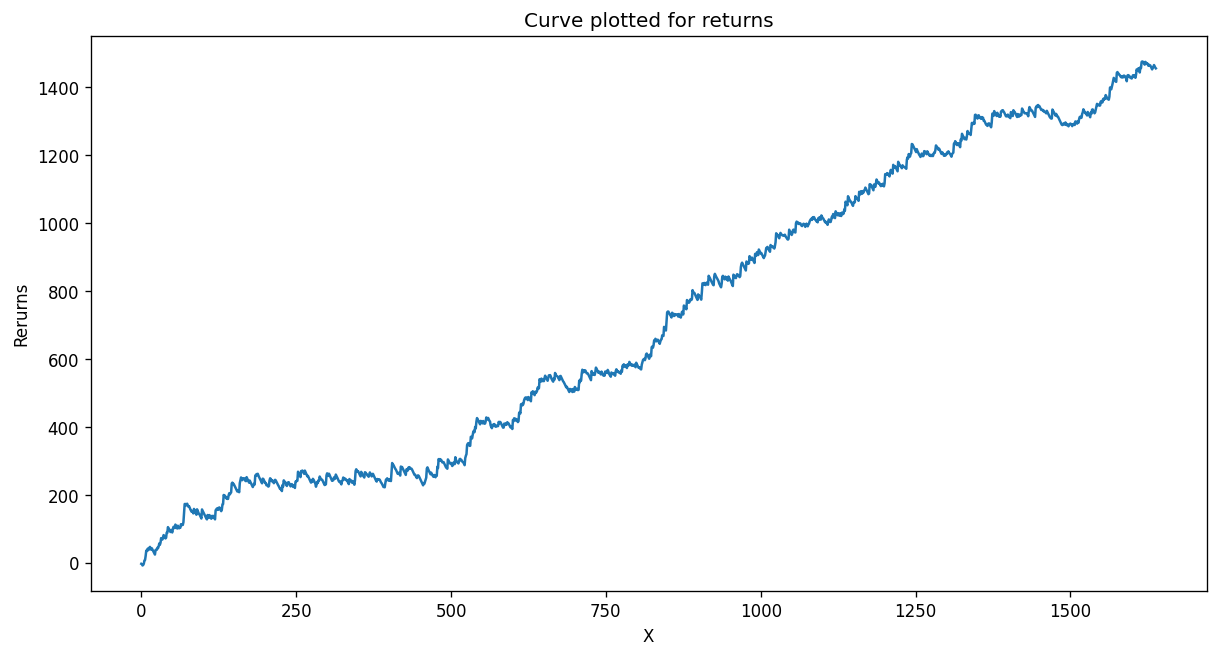

In [28]:
copy_trades = trades.copy()
copy_trades['cum_sum'] = copy_trades['PnL'].cumsum()
X = np.array(range(0, len(copy_trades['cum_sum'])))
Y = copy_trades['cum_sum']
# Plotting the Graph
plt.plot(X, Y)
plt.title("Curve plotted for returns")
plt.xlabel("X")
plt.ylabel("Rerurns")
plt.show()

In [29]:
trades[trades.EntryTime > '2024-06-03 00:00:00']['PnL'].sum()

143.35186000000886

In [30]:
trades[(trades.EntryTime > '2024-12-13 00:00:00') & (trades.EntryTime < '2024-12-16 23:00:00')]

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
1584,-1,52456,52466,1331.90031,1335.8,-3.89969,-0.002928,2024-12-13 09:25:00,2024-12-13 10:15:00,None,0 days 00:50:00
1585,-1,52514,52551,1336.39896,1336.0,0.39896,0.000299,2024-12-16 10:00:00,2024-12-16 14:30:00,None,0 days 04:30:00


In [31]:
trades['PnL'].sum()

1456.1042300000595